In [1]:
import os
# 加载数据集
def load_imdb_data(path):
    assert os.path.exists(path)
    trainset, devset, testset = [], [], []
    with open(os.path.join(path, "train.txt"), "r") as fr:
        for line in fr:
            sentence_label, sentence = line.strip().lower().split("\t", maxsplit=1)
            # strip() 方法用于移除字符串头尾指定的字符（默认为空格或换行符）或字符序列。
            # ower() 方法转换字符串中所有大写字符为小写
            trainset.append((sentence, sentence_label))
    
    with open(os.path.join(path, "dev.txt"), "r") as fr:
        for line in fr:
            sentence_label, sentence = line.strip().lower().split("\t", maxsplit=1)
            devset.append((sentence, sentence_label))

    with open(os.path.join(path, "test.txt"), "r") as fr:
        for line in fr:
            sentence_label, sentence = line.strip().lower().split("\t", maxsplit=1)
            testset.append((sentence, sentence_label))
    
    return trainset, devset, testset

# 加载IMDB数据集
train_data, dev_data, test_data = load_imdb_data("./IMDB_Dataset/")

# 打印一下加载后的数据样式
print(train_data[0])

('it does seem like this film is polarizing us. you either love it or hate it. i loved it.<br /><br />i agree with the comment(s) that said, you just gotta "feel" this one.<br /><br />also, early in the film, tom cruise shows his girlfriend a painting done by monet--an impressionist painter. monet\'s style is to paint in little dabs so up close the painting looks like a mess, but from a distance, you can tell what the subject is. cruise mentions that the painting has a "vanilla sky". i believe this is a hint to the moviegoer. this movie is like that impressionist painting. it\'s impressionist filmmaking! and it\'s no coincidence that the title of the movie refers to that painting.<br /><br />this is not your typical linear plot. it requires more thought. there is symbolism and there are scenes that jump around and no, you\'re not always going to be sure what\'s going on. but at the end, all is explained.<br /><br />you will need to concentrate on this movie but i think people are makin

In [2]:
# 构造Dataset类
import paddle
import paddle.nn as nn
from paddle.io import Dataset
from utils_6.data import load_vocab

class IMDBDataset(Dataset):
    def __init__(self, examples, word2id_dict):
        super(IMDBDataset, self).__init__()
        # 词典，用于将单词转为字典索引的数字
        self.word2id_dict = word2id_dict
        # 加载后的数据集
        self.examples = self.words_to_id(examples)

    def words_to_id(self, examples):
        tmp_examples = []
        for idx, example in enumerate(examples):
            seq, label = example
            # 将单词映射为字典索引的ID， 对于词典中没有的单词用[UNK]对应的ID进行替代
            seq = [self.word2id_dict.get(word, self.word2id_dict['[UNK]']) for word in seq.split(" ")]
            label = int(label)
            tmp_examples.append([seq, label])
        return tmp_examples
    
    def __getitem__(self, idx):
        seq, lable = self.examples[idx]
        return seq, lable
    
    def __len__(self):
        return len(self.examples)
    
# 加载词表
word2id_dict = load_vocab("./IMDB_Dataset/vocab.txt")

# 实例化IMDBDataset
train_set = IMDBDataset(train_data, word2id_dict)
dev_set = IMDBDataset(dev_data, word2id_dict)
test_set = IMDBDataset(test_data, word2id_dict)

print("训练集样本数：",len(train_set))
print("样本示例：", train_set[0])

训练集样本数： 25000
样本示例： ([12, 114, 268, 37, 10, 24, 7, 84022, 2440, 25, 452, 120, 12, 40, 779, 112, 9, 403, 619, 13, 165, 1041, 17, 2, 146466, 11, 1100, 25, 39, 3633, 28663, 10, 2506, 13, 4158, 358, 8, 2, 151, 877, 4597, 287, 21, 1384, 3, 4644, 247, 31, 146467, 25606, 26222, 146468, 507, 7, 6, 2858, 8, 105, 146469, 38, 65, 547, 2, 4644, 251, 37, 3, 5877, 18, 34, 3, 19243, 25, 64, 337, 48, 2, 961, 701, 4597, 5165, 11, 2, 4644, 41, 3, 63486, 60235, 9, 250, 10, 7, 3, 3275, 6, 2, 63493, 10, 20, 7, 37, 11, 25606, 15503, 44, 25606, 146470, 4, 44, 60, 9045, 11, 2, 490, 5, 2, 20, 6415, 6, 11, 46562, 13, 255, 7, 23, 111, 716, 9899, 1076, 12, 3616, 51, 5492, 52, 7, 5302, 4, 52, 22, 159, 11, 2051, 197, 4, 1375, 298, 23, 206, 162, 6, 28, 274, 777, 162, 774, 18, 29, 2, 656, 35, 7, 26138, 13, 2230, 74, 311, 6, 6864, 19, 10, 20, 18, 9, 98, 89, 22, 242, 2, 1887, 5, 14977, 108, 104, 261, 19, 112, 94, 12, 654, 7, 50, 25, 128, 98, 43, 112, 46, 25, 325, 6, 848, 12, 47, 15, 44, 47240, 25, 74, 14975, 3782, 39, 

In [3]:
from functools import partial

def collate_fn(batch_data, pad_val=0, max_seq_len=256):
    seqs, seq_lens, labels = [], [], []
    max_len = 0
    for example in batch_data:
        seq, label = example
        # 对数据序列进行截断
        seq = seq[:max_seq_len]
        # 对数据截断并保存于seqs中
        seqs.append(seq)
        seq_lens.append(len(seq))

        labels.append(label)
        # 保存序列最大长度
        max_len = max(max_len, len(seq))

    # 对数据序列进行填充至最大长度
    for i in range(len(seqs)):
        seqs[i] = seqs[i] + [pad_val]*(max_len-len(seqs[i]))
    
    return (paddle.to_tensor(seqs), paddle.to_tensor(seq_lens)), paddle.to_tensor(labels)

In [4]:
max_seq_len = 5
batch_data = [[[1, 2, 3, 4, 5, 6], 1], [[2, 4, 6], 0]]
(seqs, seq_lens), labels = collate_fn(batch_data, pad_val=word2id_dict["[PAD]"], max_seq_len=max_seq_len)
print("seqs: ", seqs)
print("seq_lens: ", seq_lens)
print("labels: ", labels)

seqs:  Tensor(shape=[2, 5], dtype=int64, place=Place(gpu:0), stop_gradient=True,
       [[1, 2, 3, 4, 5],
        [2, 4, 6, 0, 0]])
seq_lens:  Tensor(shape=[2], dtype=int64, place=Place(gpu:0), stop_gradient=True,
       [5, 3])
labels:  Tensor(shape=[2], dtype=int64, place=Place(gpu:0), stop_gradient=True,
       [1, 0])


In [5]:
max_seq_len = 256
batch_size = 128
collate_fn = partial(collate_fn, pad_val=word2id_dict["[PAD]"], max_seq_len=max_seq_len)
train_loader = paddle.io.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=False, collate_fn=collate_fn)
dev_loader = paddle.io.DataLoader(dev_set, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn)
test_loader = paddle.io.DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn)


In [34]:
# 将双向LSTM层输出的非[PAD]位置的隐状态向量进行平均，作为整个句子的表示

class AveragePooling(nn.Layer):
    def __init__(self):
        super(AveragePooling, self).__init__()
    
    def forward(self, sequence_output, sequence_length):
        sequence_length = paddle.cast(sequence_length.unsqueeze(-1), dtype="float32") #  CAST函数用于将某种数据类型的表达式显式转换为另一种数据类型
        # 根据sequence_length生成mask矩阵，用于对Padding位置的信息进行mask
        max_len = sequence_output.shape[1]
        mask = paddle.arange(max_len) < sequence_length
        mask = paddle.cast(mask, dtype="float32").unsqueeze(-1)
        # 对序列中paddling部分进行mask
        sequence_output = paddle.multiply(sequence_output, mask)
        # 对序列中的向量取均值
        batch_mean_hidden = paddle.divide(paddle.sum(sequence_output, axis=1), sequence_length)
        return batch_mean_hidden

In [35]:
# 测试
print(paddle.arange(5))
mask = paddle.arange(5) < 4
print(mask)
mask = paddle.cast(mask, dtype="float32").unsqueeze(-1)
print(mask)

Tensor(shape=[5], dtype=int64, place=Place(gpu:0), stop_gradient=True,
       [0, 1, 2, 3, 4])
Tensor(shape=[5], dtype=bool, place=Place(gpu:0), stop_gradient=True,
       [True , True , True , True , False])
Tensor(shape=[5, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[1.],
        [1.],
        [1.],
        [1.],
        [0.]])


In [36]:
class Model_BiLSTM_FC(nn.Layer):
    def __init__(self, num_embeddings, input_size, hidden_size, num_classes=2):
        super(Model_BiLSTM_FC, self).__init__()

        # 词典大小
        self.num_embeddings = num_embeddings
        # 单位向量的维度
        self.input_size = input_size
        # LSTM隐藏层单元数量
        self.hidden_size = hidden_size
        # 情感分类类别数量
        self.num_classes = num_classes
        # 实例化嵌入层
        self.embedding_layer = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=input_size, padding_idx=0)
        # 实例化LSTM层
        self.lstm_layer = nn.LSTM(input_size=input_size, hidden_size=hidden_size, direction="bidirectional")
        # 实例化聚合层
        self.average_layer = AveragePooling()
        # 实例化输出层
        self.output_layer = nn.Linear(in_features=hidden_size*2, out_features=num_classes)

    def forward(self, inputs):
        # 对模型输入拆分为序列数据和mask
        input_ids, sequence_length = inputs
        # 获取词向量
        inputs_emb = self.embedding_layer(input_ids)
        # 使用lstm处理数据
        sequence_output, _ = self.lstm_layer(inputs_emb, sequence_length=sequence_length)
        # 使用聚合层聚合sequence_output
        batch_mean_hidden =self.average_layer(sequence_output, sequence_length)
        # 输出文本分类 logits
        logits = self.output_layer(batch_mean_hidden)

        return logits

In [37]:
# 模型训练

import time
import random
import numpy as np
from nndl_6_2 import Accuracy, RunnerV3

np.random.seed(0)
random.seed(0)
paddle.seed(0)

# 指定训练轮次
num_epochs = 3
# 指定学习率
learning_rate = 0.001
# 指定embedding的数量为词表长度
num_embeddings = len(word2id_dict)
# embedding向量的维度
input_size = 256
# LSTM网络隐状态向量的维度
hidden_size = 256

# 实例化模型
model = Model_BiLSTM_FC(num_embeddings=num_embeddings, input_size=input_size, hidden_size=hidden_size)
# 指定优化器
optimizer = paddle.optimizer.Adam(learning_rate=learning_rate, beta1=0.9, beta2=0.999, parameters=model.parameters())

# 指定损失函数
loss_fn = paddle.nn.CrossEntropyLoss()

# 指定评估指标
metric = Accuracy()

# 实例化Runner
runner = RunnerV3(model=model, optimizer=optimizer, loss_fn=loss_fn, metric=metric)

# 模型训练
start_time = time.time()
runner.train(train_loader=train_loader, dev_loader=dev_loader, num_epochs= num_epochs, eval_steps=10, log_steps=10, save_path='./checkpoints/best.pdparams')
end_time = time.time()
print("time: ", (end_time-start_time))

d:\anaconda3\lib\site-packages\paddle\fluid\dygraph\math_op_patch.py:275: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.int64, but right dtype is paddle.float32, the right dtype will convert to paddle.int64
  warnings.warn(


[Train] epoch: 0/3, step: 0/588, loss: 0.69292
[Train] epoch: 0/3, step: 10/588, loss: 0.68585
[Evaluate]  dev score: 0.50528, dev loss: 0.68537
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.50528
[Train] epoch: 0/3, step: 20/588, loss: 0.64636
[Evaluate]  dev score: 0.64424, dev loss: 0.63367
[Evaluate] best accuracy performence has been updated: 0.50528 --> 0.64424
[Train] epoch: 0/3, step: 30/588, loss: 0.48171
[Evaluate]  dev score: 0.78088, dev loss: 0.51138
[Evaluate] best accuracy performence has been updated: 0.64424 --> 0.78088
[Train] epoch: 0/3, step: 40/588, loss: 0.33618
[Evaluate]  dev score: 0.81080, dev loss: 0.41424
[Evaluate] best accuracy performence has been updated: 0.78088 --> 0.81080
[Train] epoch: 0/3, step: 50/588, loss: 0.34565
[Evaluate]  dev score: 0.83040, dev loss: 0.38535
[Evaluate] best accuracy performence has been updated: 0.81080 --> 0.83040
[Train] epoch: 0/3, step: 60/588, loss: 0.27981
[Evaluate]  dev score: 0.84304, dev loss

d:\anaconda3\lib\site-packages\fontTools\misc\py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


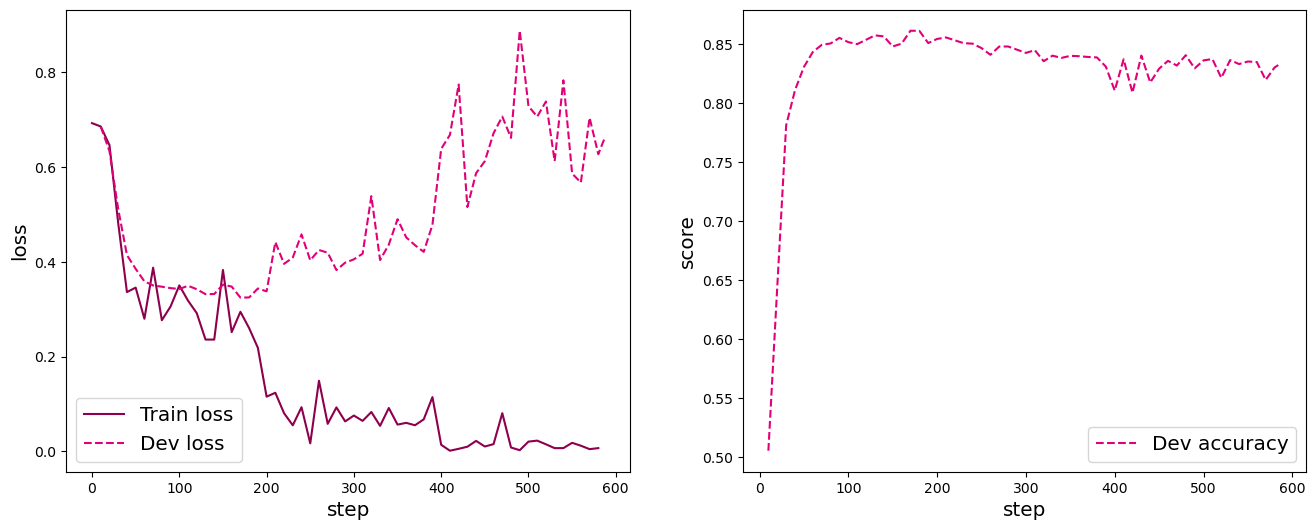

In [38]:
from nndl_6_2 import plot_training_loss_acc

# 图形名字
fig_name = './images/6.16.pdf'
# sample_step: 训练损失的采样step，即每隔多少个点选择1个点绘制
# loss_legend_loc: loss 图像的图例放置位置
# acc_legend_loc： acc 图像的图例放置位置
plot_training_loss_acc(runner=runner, fig_name=fig_name, fig_size=(16, 6), sample_step=10, loss_legend_loc="lower left", acc_legend_loc="lower right")


In [39]:
model_path = './checkpoints/best.pdparams'

runner.load_model(model_path=model_path)

accuracy, _ = runner.evaluate(test_loader)
print(f"Evaluate on test set, Accuracy: {accuracy:.5f}")

d:\anaconda3\lib\site-packages\paddle\fluid\dygraph\math_op_patch.py:275: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.int64, but right dtype is paddle.float32, the right dtype will convert to paddle.int64
  warnings.warn(


Evaluate on test set, Accuracy: 0.85856


In [40]:
id2label = {0: "消极情绪", 1: "积极情绪"}
text = "this movie is so great. I watched it three times already"
# 处理单条文本
sentence = text.split(" ")
# words = [word2id_dict[word] if word in word2id_dict else word2id_dict['[UNK]'] for word in sentence]
words = []
for word in sentence:
    if word in word2id_dict:
        words.append(word2id_dict[word])
    else:
        words.append(word2id_dict['[UNK]'])
words = words[: max_seq_len]

print(words)

sequence_length = paddle.to_tensor([len(words)], dtype="int64")
# print(sequence_length)
words = paddle.to_tensor(words, dtype="int64").unsqueeze(0)
# print(words)

# 使用模型进行预测
logits = runner.predict((words, sequence_length))
# print(logits)
max_label_id = paddle.argmax(logits, axis=-1).numpy()[0]
# print(max_label_id)
pred_label = id2label[max_label_id]
print("Label: ", pred_label)


[10, 20, 7, 38, 1208, 1, 273, 12, 284, 286, 445]
Label:  积极情绪


In [41]:
# 使用Paddle内置的单向LSTM进行文本分类实验

class AveragePooling(nn.Layer):
    def __init__(self):
        super(AveragePooling, self).__init__()
    
    def forward(self, sequence_output, sequence_length):
        sequence_length = paddle.cast(sequence_length.unsqueeze(-1), dtype="float32")
        # 根据sequence_length生成mask矩阵，用于对Padding位置的信息进行mask
        max_len = sequence_output.shape[1]
        mask = paddle.arange(max_len) < sequence_length
        mask = paddle.cast(mask, dtype="float32").unsqueeze(-1)
        # 对序列中paddling部分进行mask
        sequence_output = paddle.multiply(sequence_output, mask)
        # 对序列中的向量取均值
        batch_mean_hidden = paddle.divide(paddle.sum(sequence_output, axis=1), sequence_length)

        return batch_mean_hidden
    
class Model_BiLSTM_FC(nn.Layer):
    def __init__(self, num_embeddings, input_size, hidden_size, num_classes=2):
        super(Model_BiLSTM_FC, self).__init__()
        # 词典大小
        self.num_embeddings = num_embeddings
        # 单词向量维度
        self.input_size = input_size
        # LSTM隐藏单元数量
        self.hidden_size = hidden_size
        # 情感分类类别数量
        self.num_classes = num_classes

        # 实例化嵌入层
        self.embedding_layer = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=input_size, padding_idx=0)
        # 实例化LSTM层
        self.lstm_layer = nn.LSTM(input_size=input_size, hidden_size=hidden_size, direction="forward")
        # 实例化聚合层
        self.average_layer = AveragePooling()
        # 实例化输出层
        self.output_layer = nn.Linear(hidden_size, num_classes)

    def forward(self, inputs):
        # 对模型输入拆分为序列数据和mask
        input_ids, sequence_length = inputs
        # 获取词向量
        inputs_emb = self.embedding_layer(input_ids)
        # 使用lstm处理数据
        sequence_output, _ = self.lstm_layer(inputs_emb, sequence_length=sequence_length)
        # 使用聚合层聚合sequence_output
        batch_mean_hidden = self.average_layer(sequence_output, sequence_length)
        # 输出文本分类logits
        logits = self.output_layer(batch_mean_hidden)

        return logits

In [42]:
import time
import random
import numpy as np
from nndl_6_2 import Accuracy, RunnerV3

np.random.seed(0)
random.seed(0)
paddle.seed(0)

# 指定训练轮次
num_epochs = 3
# 指定学习率
learning_rate = 0.001
# 指定embedding的数量为词表长度
num_embeddings = len(word2id_dict)
# embedding向量的维度
input_size = 256
# LSTM网络隐状态向量的维度
hidden_size = 256

# 实例化模型
model = Model_BiLSTM_FC(num_embeddings=num_embeddings, input_size=input_size, hidden_size=hidden_size)
# 指定优化器
optimizer = paddle.optimizer.Adam(learning_rate=learning_rate, beta1=0.9, beta2=0.999, parameters=model.parameters())
# 指定损失函数
loss_fn = paddle.nn.CrossEntropyLoss()
# 指定评估指标
metric = Accuracy()
# 实例化Runner
runner = RunnerV3(model=model, optimizer=optimizer, loss_fn=loss_fn, metric=metric)

# 模型训练
start_time = time.time()
runner.train(train_loader=train_loader, dev_loader=dev_loader, num_epochs = 3, eval_steps=10, log_steps=10, save_path="./checkpoints/best_forward.pdparams")
end_time = time.time()
print("time: ", (end_time-start_time))

[Train] epoch: 0/3, step: 0/588, loss: 0.69309
[Train] epoch: 0/3, step: 10/588, loss: 0.68730
[Evaluate]  dev score: 0.52616, dev loss: 0.68682
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.52616
[Train] epoch: 0/3, step: 20/588, loss: 0.64594
[Evaluate]  dev score: 0.63168, dev loss: 0.62767
[Evaluate] best accuracy performence has been updated: 0.52616 --> 0.63168
[Train] epoch: 0/3, step: 30/588, loss: 0.63806
[Evaluate]  dev score: 0.57312, dev loss: 0.63488
[Train] epoch: 0/3, step: 40/588, loss: 0.60475
[Evaluate]  dev score: 0.78176, dev loss: 0.61603
[Evaluate] best accuracy performence has been updated: 0.63168 --> 0.78176
[Train] epoch: 0/3, step: 50/588, loss: 0.57504
[Evaluate]  dev score: 0.80440, dev loss: 0.57197
[Evaluate] best accuracy performence has been updated: 0.78176 --> 0.80440
[Train] epoch: 0/3, step: 60/588, loss: 0.45227
[Evaluate]  dev score: 0.81272, dev loss: 0.45188
[Evaluate] best accuracy performence has been updated: 0.80440 --

In [43]:
model_path = './checkpoints/best_forward.pdparams'
runner.load_model(model_path=model_path)
accuracy, _ =runner.evaluate(test_loader)
print(f"Evaluate on test set, Accuracy: {accuracy:.5f}")

Evaluate on test set, Accuracy: 0.85752


In [12]:
# 由于之前实现的LSTM默认只返回最后时刻的隐状态，然而本实验中需要用到所有时刻的隐状态向量，因此需要对自己实现的LSTM进行修改，使其返回序列向量
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
# 声明LSTM和相关参数
class LSTM(nn.Layer):
    def __init__(self, input_size, hidden_size, Wi_attr=None, Wf_attr=None, Wo_attr=None, Wc_attr=None,
                 Ui_attr=None, Uf_attr=None, Uo_attr=None, Uc_attr=None, bi_attr=None, bf_attr=None,
                 bo_attr=None, bc_attr=None):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # 初始化模型参数
        self.W_i = paddle.create_parameter(shape=[input_size, hidden_size], dtype="float32", attr=Wi_attr)
        self.W_f = paddle.create_parameter(shape=[input_size, hidden_size], dtype="float32", attr=Wf_attr)
        self.W_o = paddle.create_parameter(shape=[input_size, hidden_size], dtype="float32", attr=Wo_attr)
        self.W_c = paddle.create_parameter(shape=[input_size, hidden_size], dtype="float32", attr=Wc_attr)
        self.U_i = paddle.create_parameter(shape=[hidden_size, hidden_size], dtype="float32", attr=Ui_attr)
        self.U_f = paddle.create_parameter(shape=[hidden_size, hidden_size], dtype="float32", attr=Uf_attr)
        self.U_o = paddle.create_parameter(shape=[hidden_size, hidden_size], dtype="float32", attr=Uo_attr)
        self.U_c = paddle.create_parameter(shape=[hidden_size, hidden_size], dtype="float32", attr=Uc_attr)
        self.b_i = paddle.create_parameter(shape=[1, hidden_size], dtype="float32", attr=bi_attr)
        self.b_f = paddle.create_parameter(shape=[1, hidden_size], dtype="float32", attr=bf_attr)
        self.b_o = paddle.create_parameter(shape=[1, hidden_size], dtype="float32", attr=bo_attr)
        self.b_c = paddle.create_parameter(shape=[1, hidden_size], dtype="float32", attr=bc_attr)
    
    # 初始化状态向量和隐状态向量
    def init_state(self, batch_size):
        hidden_state = paddle.zeros(shape=[batch_size, self.hidden_size], dtype="float32")
        cell_state = paddle.zeros(shape=[batch_size, self.hidden_size], dtype="float32")
        hidden_state.stop_gradient = False
        cell_state .stop_gradient = False
        return hidden_state, cell_state

    # 定义前向计算
    def forward(self, inputs, states=None, sequence_length=None):
        batch_size, seq_len, input_size = inputs.shape  # inputs batch_size x seq_len x input_size

        if states is None:
            states = self.init_state(batch_size)
        hidden_state, cell_state = states

        outputs = []
        # 执行LSTM计算，包括：隐藏门、输入门、遗忘门、候选状态向量、状态向量和隐状态向量
        for step in range(seq_len):
            input_step = inputs[:, step, :]
            I_gate = F.sigmoid(paddle.matmul(input_step, self.W_i) + paddle.matmul(hidden_state, self.U_i) + self.b_i)
            F_gate = F.sigmoid(paddle.matmul(input_step, self.W_f) + paddle.matmul(hidden_state, self.U_f) + self.b_f)
            O_gate = F.sigmoid(paddle.matmul(input_step, self.W_o) + paddle.matmul(hidden_state, self.U_o) + self.b_o)
            C_tilde = F.tanh(paddle.matmul(input_step, self.W_c) + paddle.matmul(hidden_state, self.U_c) + self.b_c)
            cell_state = F_gate * cell_state + I_gate * C_tilde
            hidden_state = O_gate * F.tanh(cell_state)
            
            outputs.append(hidden_state.unsqueeze(axis=1))

        outputs = paddle.concat(outputs, axis=1)
        return outputs

In [13]:
# 将nn.LSTM换为自己实现的LSTM模型
class AveragePooling(nn.Layer):
    def __init__(self):
        super(AveragePooling, self).__init__()
    
    def forward(self, sequence_output, sequence_length):
        sequence_length = paddle.cast(sequence_length.unsqueeze(-1), dtype="float32")
        # 根据sequence_length生成mask矩阵，用于对Padding位置的信息进行mask
        max_len = sequence_output.shape[1]
        mask = paddle.arange(max_len) < sequence_length
        mask = paddle.cast(mask, dtype="float32").unsqueeze(-1)
        # 对序列中paddling部分进行mask
        sequence_output = paddle.multiply(sequence_output, mask)
        # 对序列中的向量取均值
        batch_mean_hidden = paddle.divide(paddle.sum(sequence_output, axis=1), sequence_length)
        return batch_mean_hidden

class Model_BiLSTM_FC(nn.Layer):
    def __init__(self, num_embeddings, input_size, hidden_size, num_classes=2):
        super(Model_BiLSTM_FC, self).__init__()
        # 词典大小
        self.num_embeddings = num_embeddings
        # 单词向量的维度
        self.input_size = input_size
        # LSTM隐藏单元数量
        self.hidden_size = hidden_size
        # 情感分类类别数量
        self.num_classes = num_classes
        # 实例化嵌入层
        self.embedding_layer = nn.Embedding(num_embeddings, input_size, padding_idx=0)
        # 实例化LSTM层
        self.lstm_layer = LSTM(input_size=input_size, hidden_size=hidden_size)
        # 实例化聚合层
        self.average_layer = AveragePooling()
        # 实例化输出层
        self.output_layer = nn.Linear(hidden_size, num_classes)

    def forward(self, inputs):
        # 对模型输入拆分为序列数据和mask
        input_ids, sequence_length = inputs
        # 获取词向量
        inputs_emb = self.embedding_layer(input_ids)
        # 使用lstm处理数据
        sequence_output = self.lstm_layer(inputs_emb)
        # 使用聚合层聚合sequence_output
        batch_mean_hidden = self.average_layer(sequence_output, sequence_length)
        # 输出文本分类logits
        logits = self.output_layer(batch_mean_hidden)
        return logits

In [14]:
import time
import random
import numpy as np
from nndl_6_2 import Accuracy, RunnerV3

np.random.seed(0)
random.seed(0)
paddle.seed(0)

# 指定训练轮次
num_epochs = 3
# 指定学习率
learning_rate = 0.001
# 指定embedding的数量为词表长度
num_embeddings = len(word2id_dict)
# embedding向量的维度
input_size = 256
# LSTM网络隐状态向量的维度
hidden_size = 256

# 实例化模型
model = Model_BiLSTM_FC(num_embeddings, input_size, hidden_size=hidden_size)
# 指定优化器
optimizer = paddle.optimizer.Adam(learning_rate=learning_rate, beta1=0.9, beta2=0.999, parameters=model.parameters())
# 指定损失函数
loss_fn = paddle.nn.CrossEntropyLoss()
# 指定评估指标
metric = Accuracy()

# 实例化Runner
runner = RunnerV3(model=model, optimizer=optimizer, loss_fn=loss_fn, metric=metric)

# 模型训练
start_time = time.time()
runner.train(train_loader=train_loader, dev_loader=dev_loader, num_epochs= num_epochs, eval_steps=10, log_steps=10, save_path="./checkpoints/best_self_forward.pdparams")
end_time = time.time()
print("time: ", (end_time-start_time))

[Train] epoch: 0/3, step: 0/588, loss: 0.69291
[Train] epoch: 0/3, step: 10/588, loss: 0.69084
[Evaluate]  dev score: 0.49472, dev loss: 0.69001
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.49472
[Train] epoch: 0/3, step: 20/588, loss: 0.67459
[Evaluate]  dev score: 0.52600, dev loss: 0.66588
[Evaluate] best accuracy performence has been updated: 0.49472 --> 0.52600
[Train] epoch: 0/3, step: 30/588, loss: 0.53594
[Evaluate]  dev score: 0.74976, dev loss: 0.52569
[Evaluate] best accuracy performence has been updated: 0.52600 --> 0.74976
[Train] epoch: 0/3, step: 40/588, loss: 0.51490
[Evaluate]  dev score: 0.77648, dev loss: 0.53933
[Evaluate] best accuracy performence has been updated: 0.74976 --> 0.77648
[Train] epoch: 0/3, step: 50/588, loss: 0.47236
[Evaluate]  dev score: 0.80912, dev loss: 0.46107
[Evaluate] best accuracy performence has been updated: 0.77648 --> 0.80912
[Train] epoch: 0/3, step: 60/588, loss: 0.33950
[Evaluate]  dev score: 0.81888, dev loss

In [15]:
model_path = "./checkpoints/best_self_forward.pdparams"
runner.load_model(model_path=model_path)
accuracy, _ =runner.evaluate(test_loader)
print(f"Evaluate on test set, Accuracy: {accuracy:.5f}")

Evaluate on test set, Accuracy: 0.85800
